In [1]:
import os
import sys
sys.path.append("..")
import logging
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy
from glob import glob
from obspy import read, UTCDateTime
from redpan import inference_engine
from redpan.models import unets
from redpan.utils import sac_len_complement
from redpan.picks import extract_picks
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_devices = tf.config.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
logging.basicConfig(
    level=logging.INFO, format="%(levelname)s : %(asctime)s : %(message)s"
)

2025-07-28 10:54:30.756488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-28 10:54:30.762847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-28 10:54:30.762929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-28 10:54:30.776946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the encapsulated RED-PAN API

In [2]:
### Model selection. 
# Please make sure the model (absolute/relative) path is correct.
# assign ${mdl_hdr} with "REDPAN_30s_v2" or "REDPAN_60s_240107"
# REDPAN_30s_v2: model of 30-second-long receptive field
# REDPAN_60s_240107: model of 60-second-long receptive field
mdl_hdr = "REDPAN_60s_240107" # assign with "REDPAN_30s_v2" or "REDPAN_60s_240107"
model_path = f"../pretrained_model/{mdl_hdr}"
model_h5 = os.path.join(model_path, 'train.hdf5')
pred_npts = 6000

### prediction parameters and information
# delta, we use broadband seismometers with sample rate of 100 Hz
dt = 0.01
# sliding window length for making predictions
pred_interval_sec = 10
# set `bandpass=None` to disable waveform bandpass filtering
bandpass = [3, 45]
# Post-processing configurations. 
# This only preserve the thresholded values. Others are filled with zeros.
postprocess_config = {
    "mask_trigger": [0.3, 0.3], # trg_on and trg_off threshold
    "mask_len_thre": 0.5, # minimum length of mask in seconds
    "mask_err_win": 0.5, # potential window in seconds for mask error
    "detection_threshold": 0.5, # detection threshold for mask
    "P_threshold": 0.3, # detection threshold for P
    "S_threshold": 0.3 # detection threshold for S
}

### load the encapsulated RED-PAN API
frame = unets()
model = frame.build_mtan_R2unet(model_h5, input_size=(pred_npts, 3))
# set postprocess_config=None to disable postprocessing
picker = inference_engine(
    model=model, 
    pred_interval_sec=pred_interval_sec,
    dt=dt,
    batch_size=16,
    postprocess_config=postprocess_config
)

2025-07-28 10:54:34.580044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4425 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
INFO : 2025-07-28 10:54:41,417 : REDPAN initialized: pred_npts=6000, batch_size=16
INFO : 2025-07-28 10:54:41,599 : Created REDPAN engine with batch_size=16


### The picker can adapt waveforms in any length

#### Make predictions on the waveform shorter than model receptive field

2025-07-28 10:54:50.479844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8801


1 Trace(s) in Stream:
BW.RJOB..redpan_P | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
1 Trace(s) in Stream:
BW.RJOB..redpan_S | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
1 Trace(s) in Stream:
BW.RJOB..redpan_mask | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


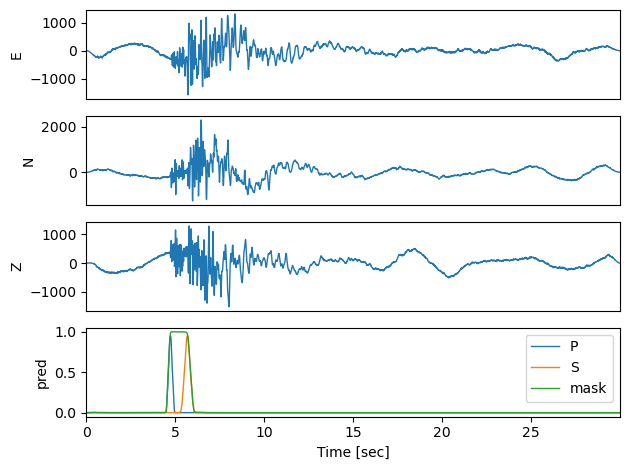

In [3]:
# read the default waveform from obspy, which is 30-second-long
wf1 = read(); wf1.sort()
# the wf
P_stream, S_stream, M_stream = picker.annotate_stream(wf1)
print(P_stream)
print(S_stream)
print(M_stream)
# plot the predictions
fig, ax = plt.subplots(4, 1)
x = np.arange(len(wf1[0].data))*0.01
x_data = [wf1[0].data, wf1[1].data, wf1[2].data]
ylabels = ['E', 'N', 'Z']
pred_label = ['P', 'S', 'mask']
pred_data = [P_stream[0].data, S_stream[0].data, M_stream[0].data]
for i in range(3):
    ax[i].plot(x, x_data[i], linewidth=1)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_xticks([])
    ax[3].plot(x, pred_data[i], linewidth=1, label=pred_label[i])
    
ax[3].set_xlim(x.min(), x.max())
ax[3].legend()
ax[3].set_ylabel('pred')
ax[3].set_xlabel('Time [sec]')
plt.tight_layout()
plt.show()

#### Make predictions on the waveform longer than model receptive field

Time taken for prediction: 9.533257
1 Trace(s) in Stream:
TW.TPUB..redpan_P | 2024-04-04T00:00:00.019500Z - 2024-04-04T00:50:00.009500Z | 100.0 Hz, 300000 samples
1 Trace(s) in Stream:
TW.TPUB..redpan_S | 2024-04-04T00:00:00.019500Z - 2024-04-04T00:50:00.009500Z | 100.0 Hz, 300000 samples
1 Trace(s) in Stream:
TW.TPUB..redpan_mask | 2024-04-04T00:00:00.019500Z - 2024-04-04T00:50:00.009500Z | 100.0 Hz, 300000 samples


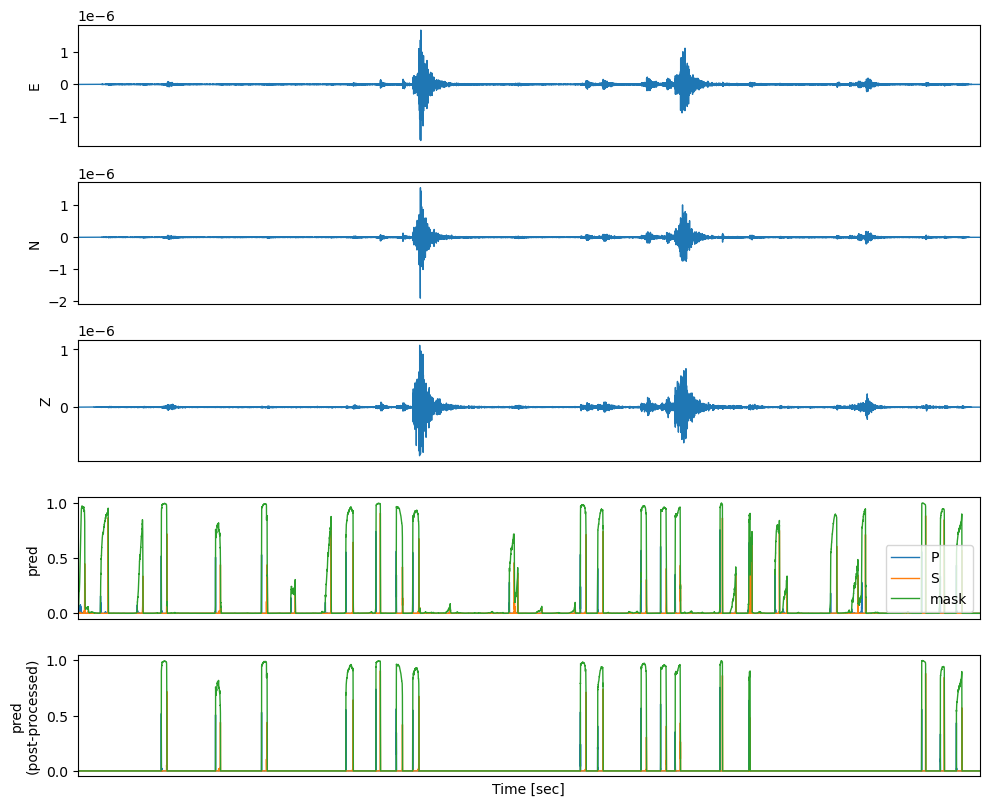

             id                timestamp           amp  prob type  pick_idx
0   TW.TPUB..BH  2024-04-04T00:04:38.239  7.078234e-09  0.52    p         0
1   TW.TPUB..BH  2024-04-04T00:04:56.599  6.432185e-08  0.72    s         0
2   TW.TPUB..BH  2024-04-04T00:07:38.579  8.427526e-09  0.51    p         1
3   TW.TPUB..BH  2024-04-04T00:07:54.849  1.535819e-08  0.44    s         1
4   TW.TPUB..BH  2024-04-04T00:10:11.639  1.520155e-08  0.53    p         2
5   TW.TPUB..BH  2024-04-04T00:10:30.029  2.956276e-08  0.44    s         2
6   TW.TPUB..BH  2024-04-04T00:14:51.879  1.203422e-08  0.55    p         3
7   TW.TPUB..BH  2024-04-04T00:15:15.719  4.547743e-08  0.64    s         3
8   TW.TPUB..BH  2024-04-04T00:16:31.779  2.648947e-08  0.74    p         4
9   TW.TPUB..BH  2024-04-04T00:16:46.519  1.438965e-07  0.90    s         4
10  TW.TPUB..BH  2024-04-04T00:17:39.399  1.593397e-08  0.56    p         5
11  TW.TPUB..BH  2024-04-04T00:17:59.909  1.572728e-07  0.42    s         5
12  TW.TPUB.

In [ ]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("IRIS")
# read the default waveform from obspy
# wf_daily = read('./test_data/TW.WTP.HL?.10.2025.021.sac')

t0 = UTCDateTime("2024-04-04")
t1 = t0 + 3000

# Customize these to your network/station/channel of interest
network, station, location = "TW", "TPUB", "*"
channel = "BH?"

# Download and preprocess
wf_daily = client.get_waveforms(
    network, station, location, channel,
    t0, t1, attach_response=True)
# stitch gaps in the waveform
wf_daily.merge(method=1, fill_value="interpolate")
# remove instrument response
wf_daily.remove_response(output="DISP") 
# detrend
wf_daily.detrend('linear')
# bandpass below Nyquist frequency (10 Hz) and taper
wf_daily.filter('bandpass', freqmin=1, freqmax=8).taper(0.05)
# resample to 100 Hz
wf_daily.resample(100)
# make sure the waveform length is the same across all traces
wf_daily = sac_len_complement(wf_daily)
# E-N-Z order
wf_daily.sort()

# Inference
t1 = UTCDateTime()
P_stream, S_stream, M_stream = picker.annotate_stream(wf_daily, postprocess=None)
t2 = UTCDateTime()
print(f"Time taken for prediction: {t2 - t1}")
print(P_stream)
print(S_stream)
print(M_stream)

# post-process the predictions (Optional)
P_stream_post, S_stream_post, M_stream_post = \
    picker._output_stream_postprocess(
        P_stream, 
        S_stream, 
        M_stream,
        postprocess_config=postprocess_config
)

# plot the predictions
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 8))
x = np.arange(len(P_stream[0].data))*0.01
x_data = [wf_daily[0].data, wf_daily[1].data, wf_daily[2].data]
ylabels = ['E', 'N', 'Z']
pred_label = ['P', 'S', 'mask']
pred_data = [P_stream[0].data, S_stream[0].data, M_stream[0].data]
pred_post_data = [
    P_stream_post[0].data, S_stream_post[0].data, M_stream_post[0].data]
for i in range(3):
    ax[i].plot(x, x_data[i], linewidth=1)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_xticks([])
    ax[3].plot(x, pred_data[i], linewidth=1, label=pred_label[i])
    ax[4].plot(x, pred_post_data[i], linewidth=1, label=pred_label[i])
plt.tight_layout()
    
ax[3].set_xlim(x.min(), x.max())
ax[4].set_xlim(x.min(), x.max())
ax[3].legend()
ax[3].set_ylabel('pred')
ax[4].set_ylabel('pred\n(post-processed)')
plt.tight_layout()
ax[4].set_xlabel('Time [sec]')
plt.show()

# extract pick and convert to pandas.DataFrame object
station_id = wf_daily[0].id[:-1]
pick_df = extract_picks(
    wf_daily, 
    P_stream, 
    S_stream, 
    M_stream, 
    station_id=station_id,
    dt=0.01,
    p_amp_estimate_sec=1, 
    s_amp_estimate_sec=3,
    starttime=None,
    endtime=None,
    args={"detection_threshold":0.5, "P_threshold":0.3, "S_threshold":0.3}
)
print(pick_df)